Importing the libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary
from torchvision.models import ResNet50_Weights
from tqdm import tqdm
import torch.nn.functional as F
import os
from os.path import join
import random
from tensorboardX import SummaryWriter
from utils.uan_utils import *
if not hasattr(collections, 'Iterable'):
    import collections.abc
    collections.Iterable = collections.abc.Iterable
from easydl import *
import collections
from collections import Counter

[easydl] tensorflow not available!


Setting the device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


Seeding function

In [3]:
# def seed_everything(seed=1234):
#     random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
#     np.random.seed(seed)
#     import os
#     os.environ['PYTHONHASHSEED'] = str(seed)

# seed_everything()

Defining the args beings used throughout the code

In [4]:
min_step = 45 # minimum steps to run. run epochs until it exceeds the minStep
lr = 0.001 # learning rate for new layers. learning rate for finetune is 1/10 of lr
weight_decay = 0.0005
momentum = 0.9
log_interval = 1
test_interval = 10

# Test specific varaibles 
w_0 = 0.5

# Setting which dataset to use
name = 'office'
# Setting the root path to the dataset
root_path = 'data/office'

# Setting the source and target domain
source = 0 # amazon
target = 1 # dslr

# Setting the number of classes
n_total = 31
n_share = 10
n_source_private = 10

# Dataloader settings
class_balance = True
batch_size = 32
data_workers = 0

Logger initialization

In [5]:
log_dir = "logs"
logger = SummaryWriter(log_dir)

Office-31 dataset setup using custom loader D -> A experiment

In [6]:
from dataset.data_loader import Office31Dataset

data_path = 'usfda_office_31_DtoA'

# Data transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
source_train_dataset = Office31Dataset(root_dir=data_path, split='train', domain='source', transform=transform)
target_train_dataset = Office31Dataset(root_dir=data_path, split='train', domain='target', transform=transform)
source_val_dataset = Office31Dataset(root_dir=data_path, split='val', domain='source', transform=transform)
target_val_dataset = Office31Dataset(root_dir=data_path, split='val', domain='target', transform=transform)

# Create DataLoaders
source_train_loader = DataLoader(source_train_dataset, batch_size=64, shuffle=True)
target_train_loader = DataLoader(target_train_dataset, batch_size=64, shuffle=True)
source_val_loader = DataLoader(source_val_dataset, batch_size=64, shuffle=False)
target_val_loader = DataLoader(target_val_dataset, batch_size=64, shuffle=False)

# Checking the size of these data loaders
print('source_train_loader size:', len(source_train_loader))
print('target_train_loader size:', len(target_train_loader))
print('source_val_loader size:', len(source_val_loader))
print('target_val_loader size:', len(target_val_loader))

# Checking the number of classes in the source and target datasets
print('Number of classes in the source dataset:', source_train_dataset.get_num_classes())
print('Number of classes in the target dataset:', target_train_dataset.get_num_classes())


# Test the DataLoader
for batch in source_train_loader:
    images = batch['image']   # Shape: (32, 3, 224, 224)
    labels = batch['label']   # Shape: (32,)
    filenames = batch['filename']
    print(f"Batch Image Shape: {images.shape}")
    print(f"Labels Shape: {labels.shape}")
    print(f"Labels: {labels}")
    break

C = ['back_pack', 'calculator', 'keyboard', 'monitor', 'mouse', 'mug', 'bike', 'laptop_computer', 'headphones', 'projector']
Cs_dash = ['bike_helmet', 'bookcase', 'bottle', 'desk_chair', 'desk_lamp', 'desktop_computer', 'file_cabinet', 'letter_tray', 'mobile_phone', 'paper_notebook']
Ct_dash = ['pen', 'phone', 'printer', 'punchers', 'ring_binder', 'ruler', 'scissors', 'speaker', 'stapler', 'tape_dispenser', 'trash_can']

# Setting the classes length for use in the models
source_classes = source_train_dataset.get_num_classes()
target_classes = target_train_dataset.get_num_classes()
common_classes = len(C)
print('Number of classes in the source dataset:', source_classes)
print('Number of classes in the target dataset:', target_classes)
print('Number of common classes:', common_classes)

Loaded 3500 images from usfda_office_31_DtoA/source_images/train
Number of classes: 20
Loaded 21966 images from usfda_office_31_DtoA/target_images/train
Number of classes: 21
Loaded 73 images from usfda_office_31_DtoA/source_images/val
Number of classes: 20
Loaded 398 images from usfda_office_31_DtoA/target_images/val
Number of classes: 21
source_train_loader size: 55
target_train_loader size: 344
source_val_loader size: 2
target_val_loader size: 7
Number of classes in the source dataset: 20
Number of classes in the target dataset: 21
Batch Image Shape: torch.Size([64, 3, 224, 224])
Labels Shape: torch.Size([64])
Labels: tensor([ 0, 19, 15,  8,  7, 18, 10, 10, 12, 14,  6, 13,  7, 16,  6, 16,  3,  6,
        10,  3, 12, 14, 13,  9, 18, 13,  6,  2,  4, 18, 10,  8, 13,  4, 18, 18,
         7, 19, 14, 12,  9, 16,  9,  0, 13, 12,  6,  3, 13, 12, 11, 10,  8, 13,
        19,  4, 15,  9,  9, 18, 10, 17, 17, 18])
Number of classes in the source dataset: 20
Number of classes in the target datase

Office-31 data setup using UAN approach

In [7]:
class Dataset:
    def __init__(self, path, domains, files, prefix):
        self.path = path
        self.prefix = prefix
        self.domains = domains
        self.files = [(join(path, file)) for file in files]
        self.prefixes = [self.prefix] * len(self.domains)

dataset = None
if name == 'office':
    dataset = Dataset(
    path=root_path,
    domains=['amazon', 'dslr', 'webcam'],
    files=[
        'amazon_reorgnized.txt',
        'dslr_reorgnized.txt',
        'webcam_reorgnized.txt'
    ],
    prefix=root_path)
elif name == 'officehome':
    dataset = Dataset(
    path=root_path,
    domains=['Art', 'Clipart', 'Product', 'Real_World'],
    files=[
        'Art.txt',
        'Clipart.txt',
        'Product.txt',
        'Real_World.txt'
    ],
    prefix=root_path)
elif name == 'visda2017':
    dataset = Dataset(
    path=root_path,
    domains=['train', 'validation'],
    files=[
        'train/image_list.txt',
        'validation/image_list.txt',
    ],
    prefix=root_path)
    dataset.prefixes = [join(dataset.path, 'train'), join(dataset.path, 'validation')]
else:
    raise Exception(f'dataset {name} not supported!')

source_domain_name = dataset.domains[source]
target_domain_name = dataset.domains[target]
source_file = dataset.files[source]
target_file = dataset.files[target]


In [8]:
from torchvision.transforms.transforms import *

'''
assume classes across domains are the same.
[0 1 ..................................................................... N - 1]
|----common classes --||----source private classes --||----target private classes --|
'''
a, b, c = n_share, n_source_private, n_total
c = c - a - b
common_classes = [i for i in range(a)]
source_private_classes = [i + a for i in range(b)]
target_private_classes = [i + a + b for i in range(c)]

source_classes = common_classes + source_private_classes
target_classes = common_classes + target_private_classes

train_transform = Compose([
    Resize(256),
    RandomCrop(224),
    RandomHorizontalFlip(),
    ToTensor()
])

test_transform = Compose([
    Resize(256),
    CenterCrop(224),
    ToTensor()
])

source_train_ds = FileListDataset(list_path=source_file, path_prefix=dataset.prefixes[source],
                            transform=train_transform, filter=(lambda x: x in source_classes))
source_test_ds = FileListDataset(list_path=source_file,path_prefix=dataset.prefixes[source],
                            transform=test_transform, filter=(lambda x: x in source_classes))
target_train_ds = FileListDataset(list_path=target_file, path_prefix=dataset.prefixes[target],
                            transform=train_transform, filter=(lambda x: x in target_classes))
target_test_ds = FileListDataset(list_path=target_file, path_prefix=dataset.prefixes[target],
                            transform=test_transform, filter=(lambda x: x in target_classes))

classes = source_train_ds.labels
freq = Counter(classes)
class_weight = {x : 1.0 / freq[x] if class_balance else 1.0 for x in freq}

source_weights = [class_weight[x] for x in source_train_ds.labels]
sampler = WeightedRandomSampler(source_weights, len(source_train_ds.labels))

source_train_dl = DataLoader(dataset=source_train_ds, batch_size=batch_size,
                             sampler=sampler, num_workers=data_workers, drop_last=True)
source_test_dl = DataLoader(dataset=source_test_ds, batch_size=batch_size, shuffle=False,
                             num_workers=data_workers, drop_last=False)
target_train_dl = DataLoader(dataset=target_train_ds, batch_size=batch_size,shuffle=True,
                             num_workers=data_workers, drop_last=True)
target_test_dl = DataLoader(dataset=target_test_ds, batch_size=batch_size, shuffle=False,
                             num_workers=data_workers, drop_last=False)

print('source_train_dl size:', len(source_train_dl))
print('target_train_dl size:', len(target_train_dl))
print('source_test_dl size:', len(source_test_dl))
print('target_test_dl size:', len(target_test_dl))

source_train_dl size: 56
target_train_dl size: 10
source_test_dl size: 57
target_test_dl size: 11


Checking a sample from the source and target train loaders

In [9]:
# Checking the sizes of one batch of the data loaders
for im_source, label_source in source_train_dl:
    print(f"Source Image Shape: {im_source.shape}")
    print(f"Source Label Shape: {label_source.shape}")
    break

for im_target, label_target in target_train_dl:
    print(f"Target Image Shape: {im_target.shape}")
    print(f"Target Label Shape: {label_target.shape}")
    break

Source Image Shape: torch.Size([32, 3, 224, 224])
Source Label Shape: torch.Size([32])
Target Image Shape: torch.Size([32, 3, 224, 224])
Target Label Shape: torch.Size([32])


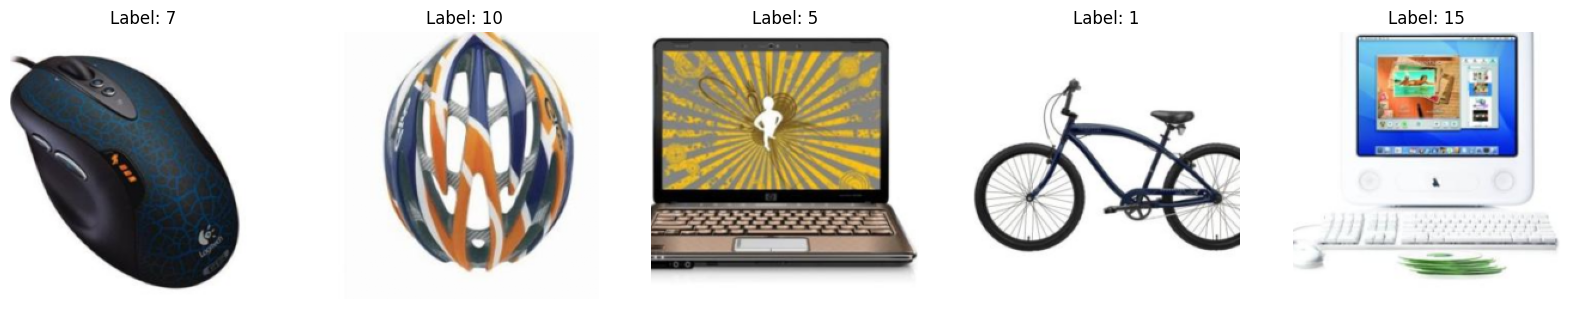

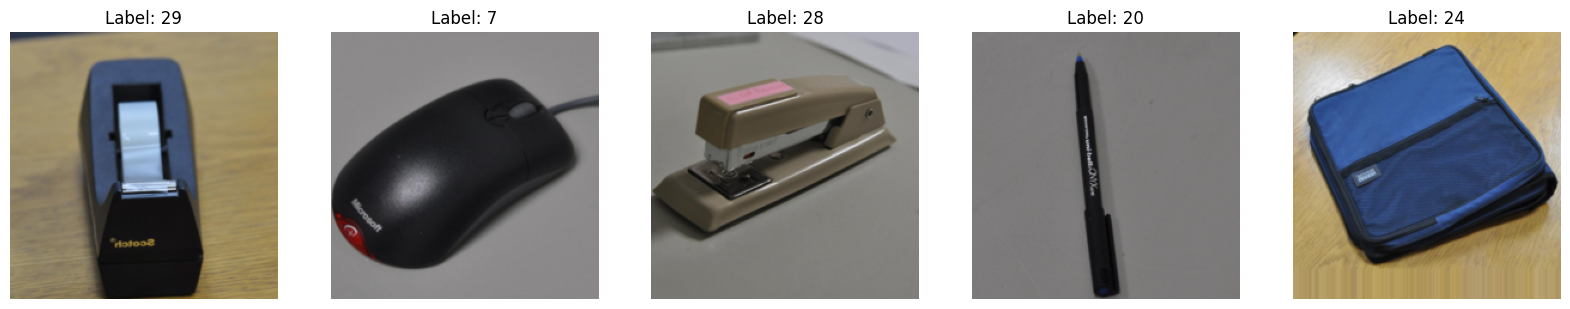

In [10]:
# Visualizing 5 images from a batch
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    ax[i].imshow(im_source[i].permute(1, 2, 0))
    ax[i].set_title(f"Label: {label_source[i]}")
    ax[i].axis('off')
plt.show()

fig, ax = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    ax[i].imshow(im_target[i].permute(1, 2, 0))
    ax[i].set_title(f"Label: {label_target[i]}")
    ax[i].axis('off')
plt.show()

Loading in the UAN model

In [11]:
class BaseFeatureExtractor(nn.Module):
    def forward(self, *input):
        pass

    def __init__(self):
        super(BaseFeatureExtractor, self).__init__()

    def output_num(self):
        pass

    def train(self, mode=True):
        # freeze BN mean and std
        for module in self.children():
            if isinstance(module, nn.BatchNorm2d):
                module.train(False)
            else:
                module.train(mode)


class ResNet50Fc(BaseFeatureExtractor):
    """
    ** input image should be in range of [0, 1]**
    """
    def __init__(self,model_path=None, normalize=True):
        super(ResNet50Fc, self).__init__()
        if model_path:
            if os.path.exists(model_path):
                self.model_resnet = models.resnet50(pretrained=False)
                self.model_resnet.load_state_dict(torch.load(model_path))
            else:
                raise Exception('invalid model path!')
        else:
            print("Using pretrained ImageNet weights")
            self.model_resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

        if model_path or normalize:
            # pretrain model is used, use ImageNet normalization
            self.normalize = True
            self.register_buffer('mean', torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
            self.register_buffer('std', torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))
        else:
            self.normalize = False

        model_resnet = self.model_resnet
        self.conv1 = model_resnet.conv1
        self.bn1 = model_resnet.bn1
        self.relu = model_resnet.relu
        self.maxpool = model_resnet.maxpool
        self.layer1 = model_resnet.layer1
        self.layer2 = model_resnet.layer2
        self.layer3 = model_resnet.layer3
        self.layer4 = model_resnet.layer4
        self.avgpool = model_resnet.avgpool
        self.__in_features = model_resnet.fc.in_features

    def forward(self, x):
        if self.normalize:
            x = (x - self.mean) / self.std
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return x

    def output_num(self):
        return self.__in_features

class CLS(nn.Module):
    """
    a two-layer MLP for classification
    """
    def __init__(self, in_dim, out_dim, bottle_neck_dim=256):
        super(CLS, self).__init__()
        self.bottleneck = nn.Linear(in_dim, bottle_neck_dim)
        self.fc = nn.Linear(bottle_neck_dim, out_dim)
        self.main = nn.Sequential(self.bottleneck, self.fc, nn.Softmax(dim=-1))

    def forward(self, x):
        out = [x]
        for module in self.main.children():
            x = module(x)
            out.append(x)
        return out


class AdversarialNetwork(nn.Module):
    """
    AdversarialNetwork with a gredient reverse layer.
    its ``forward`` function calls gredient reverse layer first, then applies ``self.main`` module.
    """
    def __init__(self, in_feature):
        super(AdversarialNetwork, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(in_feature, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024,1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )
        self.grl = GradientReverseModule(lambda step: aToBSheduler(step, 0.0, 1.0, gamma=10, max_iter=10000))

    def forward(self, x):
        x_ = self.grl(x)
        y = self.main(x_)
        return y


In [12]:
model_dict = {
        'resnet50': ResNet50Fc,
    }

class TotalNet(nn.Module):
    def __init__(self):
        super(TotalNet, self).__init__()
        self.feature_extractor = model_dict['resnet50']()
        classifier_output_dim = len(source_classes)
        self.classifier = CLS(self.feature_extractor.output_num(), classifier_output_dim, bottle_neck_dim=256)
        self.discriminator = AdversarialNetwork(256)
        self.discriminator_separate = AdversarialNetwork(256)

    def forward(self, x):
        f = self.feature_extractor(x)
        f, _, __, y = self.classifier(f)
        d = self.discriminator(_)
        d_0 = self.discriminator_separate(_)
        return y, d, d_0


totalNet = TotalNet().to(device)

feature_extractor = totalNet.feature_extractor.train(True)
classifier = totalNet.classifier.train(True)
discriminator = totalNet.discriminator.train(True)
discriminator_separate = totalNet.discriminator_separate.train(True)


# Checking the model architecture
summary(totalNet, input_size=(32, 3, 224, 224))

Using pretrained ImageNet weights


Layer (type:depth-idx)                        Output Shape              Param #
TotalNet                                      [32, 20]                  --
├─ResNet50Fc: 1-1                             [32, 2048]                2,049,000
│    └─Conv2d: 2-1                            [32, 64, 112, 112]        9,408
│    └─BatchNorm2d: 2-2                       [32, 64, 112, 112]        128
│    └─ReLU: 2-3                              [32, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                         [32, 64, 56, 56]          --
│    └─Sequential: 2-5                        [32, 256, 56, 56]         --
│    │    └─Bottleneck: 3-1                   [32, 256, 56, 56]         75,008
│    │    └─Bottleneck: 3-2                   [32, 256, 56, 56]         70,400
│    │    └─Bottleneck: 3-3                   [32, 256, 56, 56]         70,400
│    └─Sequential: 2-6                        [32, 512, 28, 28]         --
│    │    └─Bottleneck: 3-4                   [32, 512, 28, 28]         

Training and testing functions

In [13]:
scheduler = lambda step, initial_lr: inverseDecaySheduler(step, initial_lr, gamma=10, power=0.75, max_iter=10000)
optimizer_finetune = OptimWithSheduler(
    optim.SGD(totalNet.feature_extractor.parameters(), lr=lr / 10.0, weight_decay=weight_decay, momentum=momentum, nesterov=True),
    scheduler)
optimizer_cls = OptimWithSheduler(
    optim.SGD(totalNet.classifier.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, nesterov=True),
    scheduler)
optimizer_discriminator = OptimWithSheduler(
    optim.SGD(totalNet.discriminator.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, nesterov=True),
    scheduler)
optimizer_discriminator_separate = OptimWithSheduler(
    optim.SGD(totalNet.discriminator_separate.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, nesterov=True),
    scheduler)

global_step = 0
best_acc = 0

total_steps = tqdm(range(min_step),desc='global step')
epoch_id = 0

while global_step < min_step:

    iters = tqdm(zip(source_train_dl, target_train_dl), desc=f'epoch {epoch_id} ', total=min(len(source_train_dl), len(target_train_dl)))
    epoch_id += 1

    for i, ((im_source, label_source), (im_target, label_target)) in enumerate(iters):

        save_label_target = label_target  # for debug usage

        label_source = label_source.to(device)
        label_target = label_target.to(device)
        label_target = torch.zeros_like(label_target)

        # =========================forward pass
        im_source = im_source.to(device)
        im_target = im_target.to(device)

        fc1_s = totalNet.feature_extractor.forward(im_source)
        fc1_t = totalNet.feature_extractor.forward(im_target)

        fc1_s, feature_source, fc2_s, predict_prob_source = totalNet.classifier.forward(fc1_s)
        fc1_t, feature_target, fc2_t, predict_prob_target = totalNet.classifier.forward(fc1_t)

        domain_prob_discriminator_source = totalNet.discriminator.forward(feature_source)
        domain_prob_discriminator_target = totalNet.discriminator.forward(feature_target)

        domain_prob_discriminator_source_separate = totalNet.discriminator_separate.forward(feature_source.detach())
        domain_prob_discriminator_target_separate = totalNet.discriminator_separate.forward(feature_target.detach())

        source_share_weight = get_source_share_weight(domain_prob_discriminator_source_separate, fc2_s, domain_temperature=1.0, class_temperature=10.0)
        source_share_weight = normalize_weight(source_share_weight)
        target_share_weight = get_target_share_weight(domain_prob_discriminator_target_separate, fc2_t, domain_temperature=1.0, class_temperature=1.0)
        target_share_weight = normalize_weight(target_share_weight)
            
        # ==============================compute loss
        adv_loss = torch.zeros(1, 1).to(device)
        adv_loss_separate = torch.zeros(1, 1).to(device)

        tmp = source_share_weight * nn.BCELoss(reduction='none')(domain_prob_discriminator_source, torch.ones_like(domain_prob_discriminator_source))
        adv_loss += torch.mean(tmp, dim=0, keepdim=True)
        tmp = target_share_weight * nn.BCELoss(reduction='none')(domain_prob_discriminator_target, torch.zeros_like(domain_prob_discriminator_target))
        adv_loss += torch.mean(tmp, dim=0, keepdim=True)

        adv_loss_separate += nn.BCELoss()(domain_prob_discriminator_source_separate, torch.ones_like(domain_prob_discriminator_source_separate))
        adv_loss_separate += nn.BCELoss()(domain_prob_discriminator_target_separate, torch.zeros_like(domain_prob_discriminator_target_separate))

        # ============================== cross entropy loss
        ce = nn.CrossEntropyLoss(reduction='none')(predict_prob_source, label_source)
        ce = torch.mean(ce, dim=0, keepdim=True)

        with OptimizerManager(
                [optimizer_finetune, optimizer_cls, optimizer_discriminator, optimizer_discriminator_separate]):
            loss = ce + adv_loss + adv_loss_separate
            loss.backward()

        global_step += 1
        total_steps.update()

        if global_step % log_interval == 0:
            counter = AccuracyCounter()
            counter.addOneBatch(variable_to_numpy(one_hot(label_source, len(source_classes))), variable_to_numpy(predict_prob_source))
            acc_train = torch.tensor([counter.reportAccuracy()]).to(device)
            # logger.add_scalar('adv_loss', adv_loss, global_step)
            # logger.add_scalar('ce', ce, global_step)
            # logger.add_scalar('adv_loss_separate', adv_loss_separate, global_step)
            # logger.add_scalar('acc_train', acc_train, global_step)
            print(f'adv_loss: {adv_loss.item()}, ce: {ce.item()}, adv_loss_separate: {adv_loss_separate.item()}, acc_train: {acc_train.item()}')

        if global_step % test_interval == 0:

            counters = [AccuracyCounter() for x in range(len(source_classes) + 1)]
            with TrainingModeManager([totalNet.feature_extractor, totalNet.classifier, totalNet.discriminator_separate], train=False) as mgr, \
                Accumulator(['feature', 'predict_prob', 'label', 'domain_prob', 'before_softmax', 'target_share_weight']) as target_accumulator, \
                torch.no_grad():

                for i, (im, label) in enumerate(tqdm(target_test_dl, desc='testing')):
                    im = im.to(device)
                    label = label.to(device)

                    feature = totalNet.feature_extractor.forward(im)
                    feature, __, before_softmax, predict_prob = totalNet.classifier.forward(feature)
                    domain_prob = totalNet.discriminator_separate.forward(__)

                    target_share_weight = get_target_share_weight(domain_prob, before_softmax, domain_temperature=1.0,
                                                                class_temperature=1.0)

                    for  name in target_accumulator.names:
                        globals()[name] = variable_to_numpy(globals()[name])

                    target_accumulator.updateData(globals())

            for x in target_accumulator:
                globals()[x] = target_accumulator[x]

            def outlier(each_target_share_weight):
                return each_target_share_weight < w_0

            counters = [AccuracyCounter() for x in range(len(source_classes) + 1)]

            for (each_predict_prob, each_label, each_target_share_weight) in zip(predict_prob, label,
                                                                                target_share_weight):
                if each_label in source_classes:
                    counters[each_label].Ntotal += 1.0
                    each_pred_id = np.argmax(each_predict_prob)
                    if not outlier(each_target_share_weight[0]) and each_pred_id == each_label:
                        counters[each_label].Ncorrect += 1.0
                else:
                    counters[-1].Ntotal += 1.0
                    if outlier(each_target_share_weight[0]):
                        counters[-1].Ncorrect += 1.0

            acc_tests = [x.reportAccuracy() for x in counters if not np.isnan(x.reportAccuracy())]
            acc_test = torch.ones(1, 1) * np.mean(acc_tests)
            
            print(f'acc_test: {acc_test.item()}')
            # logger.add_scalar('acc_test', acc_test, global_step)

            data = {
                "feature_extractor": totalNet.feature_extractor.state_dict(),
                'classifier': totalNet.classifier.state_dict(),
                'discriminator': totalNet.discriminator.state_dict() if not isinstance(discriminator, Nonsense) else 1.0,
                'discriminator_separate': totalNet.discriminator_separate.state_dict(),
            }

            if acc_test > best_acc:
                best_acc = acc_test
                with open(join(log_dir, 'best.pkl'), 'wb') as f:
                    torch.save(data, f)

            with open(join(log_dir, 'current.pkl'), 'wb') as f:
                torch.save(data, f)

global step:   0%|          | 0/45 [00:00<?, ?it/s]

global step:   2%|▏         | 1/45 [00:20<15:16, 20.82s/it]

adv_loss: 1.3894751071929932, ce: 2.995896339416504, adv_loss_separate: 1.3754771947860718, acc_train: 0.0625


global step:   4%|▍         | 2/45 [00:42<15:05, 21.06s/it]

adv_loss: 1.392275333404541, ce: 2.994711399078369, adv_loss_separate: 1.390278935432434, acc_train: 0.03125


global step:   7%|▋         | 3/45 [01:02<14:37, 20.88s/it]

adv_loss: 1.381519079208374, ce: 2.997927188873291, adv_loss_separate: 1.3893375396728516, acc_train: 0.0


global step:   9%|▉         | 4/45 [01:24<14:29, 21.21s/it]

adv_loss: 1.3905816078186035, ce: 2.996574640274048, adv_loss_separate: 1.384913682937622, acc_train: 0.0625


global step:  11%|█         | 5/45 [01:46<14:17, 21.44s/it]

adv_loss: 1.3836328983306885, ce: 2.996457815170288, adv_loss_separate: 1.3866264820098877, acc_train: 0.03125


global step:  13%|█▎        | 6/45 [02:07<13:54, 21.41s/it]

adv_loss: 1.3879599571228027, ce: 2.9965524673461914, adv_loss_separate: 1.391402244567871, acc_train: 0.0625


global step:  16%|█▌        | 7/45 [02:29<13:39, 21.56s/it]

adv_loss: 1.3969240188598633, ce: 2.994697332382202, adv_loss_separate: 1.3889538049697876, acc_train: 0.125


global step:  18%|█▊        | 8/45 [02:50<13:07, 21.29s/it]

adv_loss: 1.377345085144043, ce: 2.9967153072357178, adv_loss_separate: 1.3879375457763672, acc_train: 0.03125


global step:  20%|██        | 9/45 [03:11<12:48, 21.34s/it]

adv_loss: 1.3852519989013672, ce: 2.9944658279418945, adv_loss_separate: 1.381925344467163, acc_train: 0.125


global step:  22%|██▏       | 10/45 [03:33<12:28, 21.37s/it]

adv_loss: 1.384299635887146, ce: 2.9956722259521484, adv_loss_separate: 1.3876965045928955, acc_train: 0.0625














testing: 100%|██████████| 11/11 [01:01<00:00,  5.62s/it]


acc_test: 0.09090909361839294


global step:  24%|██▍       | 11/45 [04:57<23:04, 40.72s/it]

adv_loss: 1.3932125568389893, ce: 2.9959282875061035, adv_loss_separate: 1.3888596296310425, acc_train: 0.0625


global step:  27%|██▋       | 12/45 [05:18<19:08, 34.81s/it]

adv_loss: 1.3889931440353394, ce: 2.9959359169006348, adv_loss_separate: 1.3874776363372803, acc_train: 0.0


global step:  29%|██▉       | 13/45 [05:40<16:21, 30.68s/it]

adv_loss: 1.3831069469451904, ce: 2.9951326847076416, adv_loss_separate: 1.3844199180603027, acc_train: 0.0625


global step:  31%|███       | 14/45 [06:01<14:20, 27.75s/it]

adv_loss: 1.3780914545059204, ce: 2.9977338314056396, adv_loss_separate: 1.388824701309204, acc_train: 0.03125


global step:  33%|███▎      | 15/45 [06:21<12:49, 25.66s/it]

adv_loss: 1.3810977935791016, ce: 2.99466609954834, adv_loss_separate: 1.3851209878921509, acc_train: 0.03125


global step:  36%|███▌      | 16/45 [06:43<11:48, 24.44s/it]

adv_loss: 1.3821438550949097, ce: 2.9949092864990234, adv_loss_separate: 1.3884350061416626, acc_train: 0.0625


global step:  38%|███▊      | 17/45 [07:04<10:58, 23.51s/it]

adv_loss: 1.390110969543457, ce: 2.99526047706604, adv_loss_separate: 1.3897984027862549, acc_train: 0.0625


global step:  40%|████      | 18/45 [07:26<10:15, 22.78s/it]

adv_loss: 1.3830034732818604, ce: 2.995415687561035, adv_loss_separate: 1.3919926881790161, acc_train: 0.03125


global step:  42%|████▏     | 19/45 [07:47<09:39, 22.28s/it]

adv_loss: 1.3868036270141602, ce: 2.9944465160369873, adv_loss_separate: 1.3840807676315308, acc_train: 0.03125


global step:  44%|████▍     | 20/45 [08:08<09:09, 21.97s/it]

adv_loss: 1.3829833269119263, ce: 2.9963455200195312, adv_loss_separate: 1.383066177368164, acc_train: 0.03125














testing: 100%|██████████| 11/11 [01:01<00:00,  5.61s/it]


acc_test: 0.09090909361839294


global step:  47%|████▋     | 21/45 [09:32<16:16, 40.69s/it]

adv_loss: 1.3876357078552246, ce: 2.9968464374542236, adv_loss_separate: 1.3906288146972656, acc_train: 0.03125


epoch 2 :  10%|█         | 1/10 [00:28<04:17, 28.59s/it]


KeyboardInterrupt: 

Training the model

In [ ]:
# scheduler = lambda step, initial_lr: inverseDecaySheduler(step, initial_lr, gamma=10, power=0.75, max_iter=10000)
# optimizer_finetune = OptimWithSheduler(
#     optim.SGD(feature_extractor.parameters(), lr=lr / 10.0, weight_decay=weight_decay, momentum=momentum, nesterov=True),
#     scheduler)
# optimizer_cls = OptimWithSheduler(
#     optim.SGD(classifier.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, nesterov=True),
#     scheduler)
# optimizer_discriminator = OptimWithSheduler(
#     optim.SGD(discriminator.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, nesterov=True),
#     scheduler)
# optimizer_discriminator_separate = OptimWithSheduler(
#     optim.SGD(discriminator_separate.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, nesterov=True),
#     scheduler)